# Elimination Diet for Migraines

Between January 2023 and March 2023, I followed an "elimination diet", wherein I stopped eating a number of histamine- and tyramine-rich foods, as these have been found to be associated with migraines, for example via histamine intolerance.

This is phase B, of an ABC single-study design investigation on whether certain foods may be causing my headaches.

Phase A was the data collected before I started the diet. In phase C, we will introduce the foods one-by-one.

This notebook serves to determine whether eliminating these foods had an effect on my headache frequency. If we note a drop in frequency, we can continue to phase C. If not, we can abandon this experiment for lack of evidence.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

pd.set_option('display.max_rows', 100)
sns.set_context('notebook')

In [2]:
def detect_activity(row, activity_list):
    new_row = row
    mask = [1 if activity in row["activities"] else 0 for activity in activity_list]
    new_row[3:] = mask
    return new_row

daylio = pd.read_csv(
    "data/daylio.csv",
    usecols=["full_date", "weekday", "mood", "activities"],
    index_col="full_date",
    parse_dates=True,
)
# parse activities
unique_activities = (
    daylio["activities"].str.split(r"\s*\|\s*", expand=True).stack().unique()
)
daylio["activities"] = daylio.activities.apply(lambda x: x.split(" | "))
for activity in unique_activities:
    daylio[activity] = 0
daylio = daylio.apply(lambda x: detect_activity(x, unique_activities), axis=1)
daylio.drop(columns="activities", inplace=True)
# convert moods to ordinal
mood_map = {"awful": -2, "bad": -1, "meh": 0, "good": 1, "rad": 2}
inv_mood_map = {v:k for k,v in mood_map.items()}
daylio.mood =  daylio.mood.map(mood_map)

# reverse direction so index 0 is the oldest date
daylio = daylio.reindex(index=daylio.index[::-1])

In [3]:
daylio = daylio.loc['2020-07-22':]

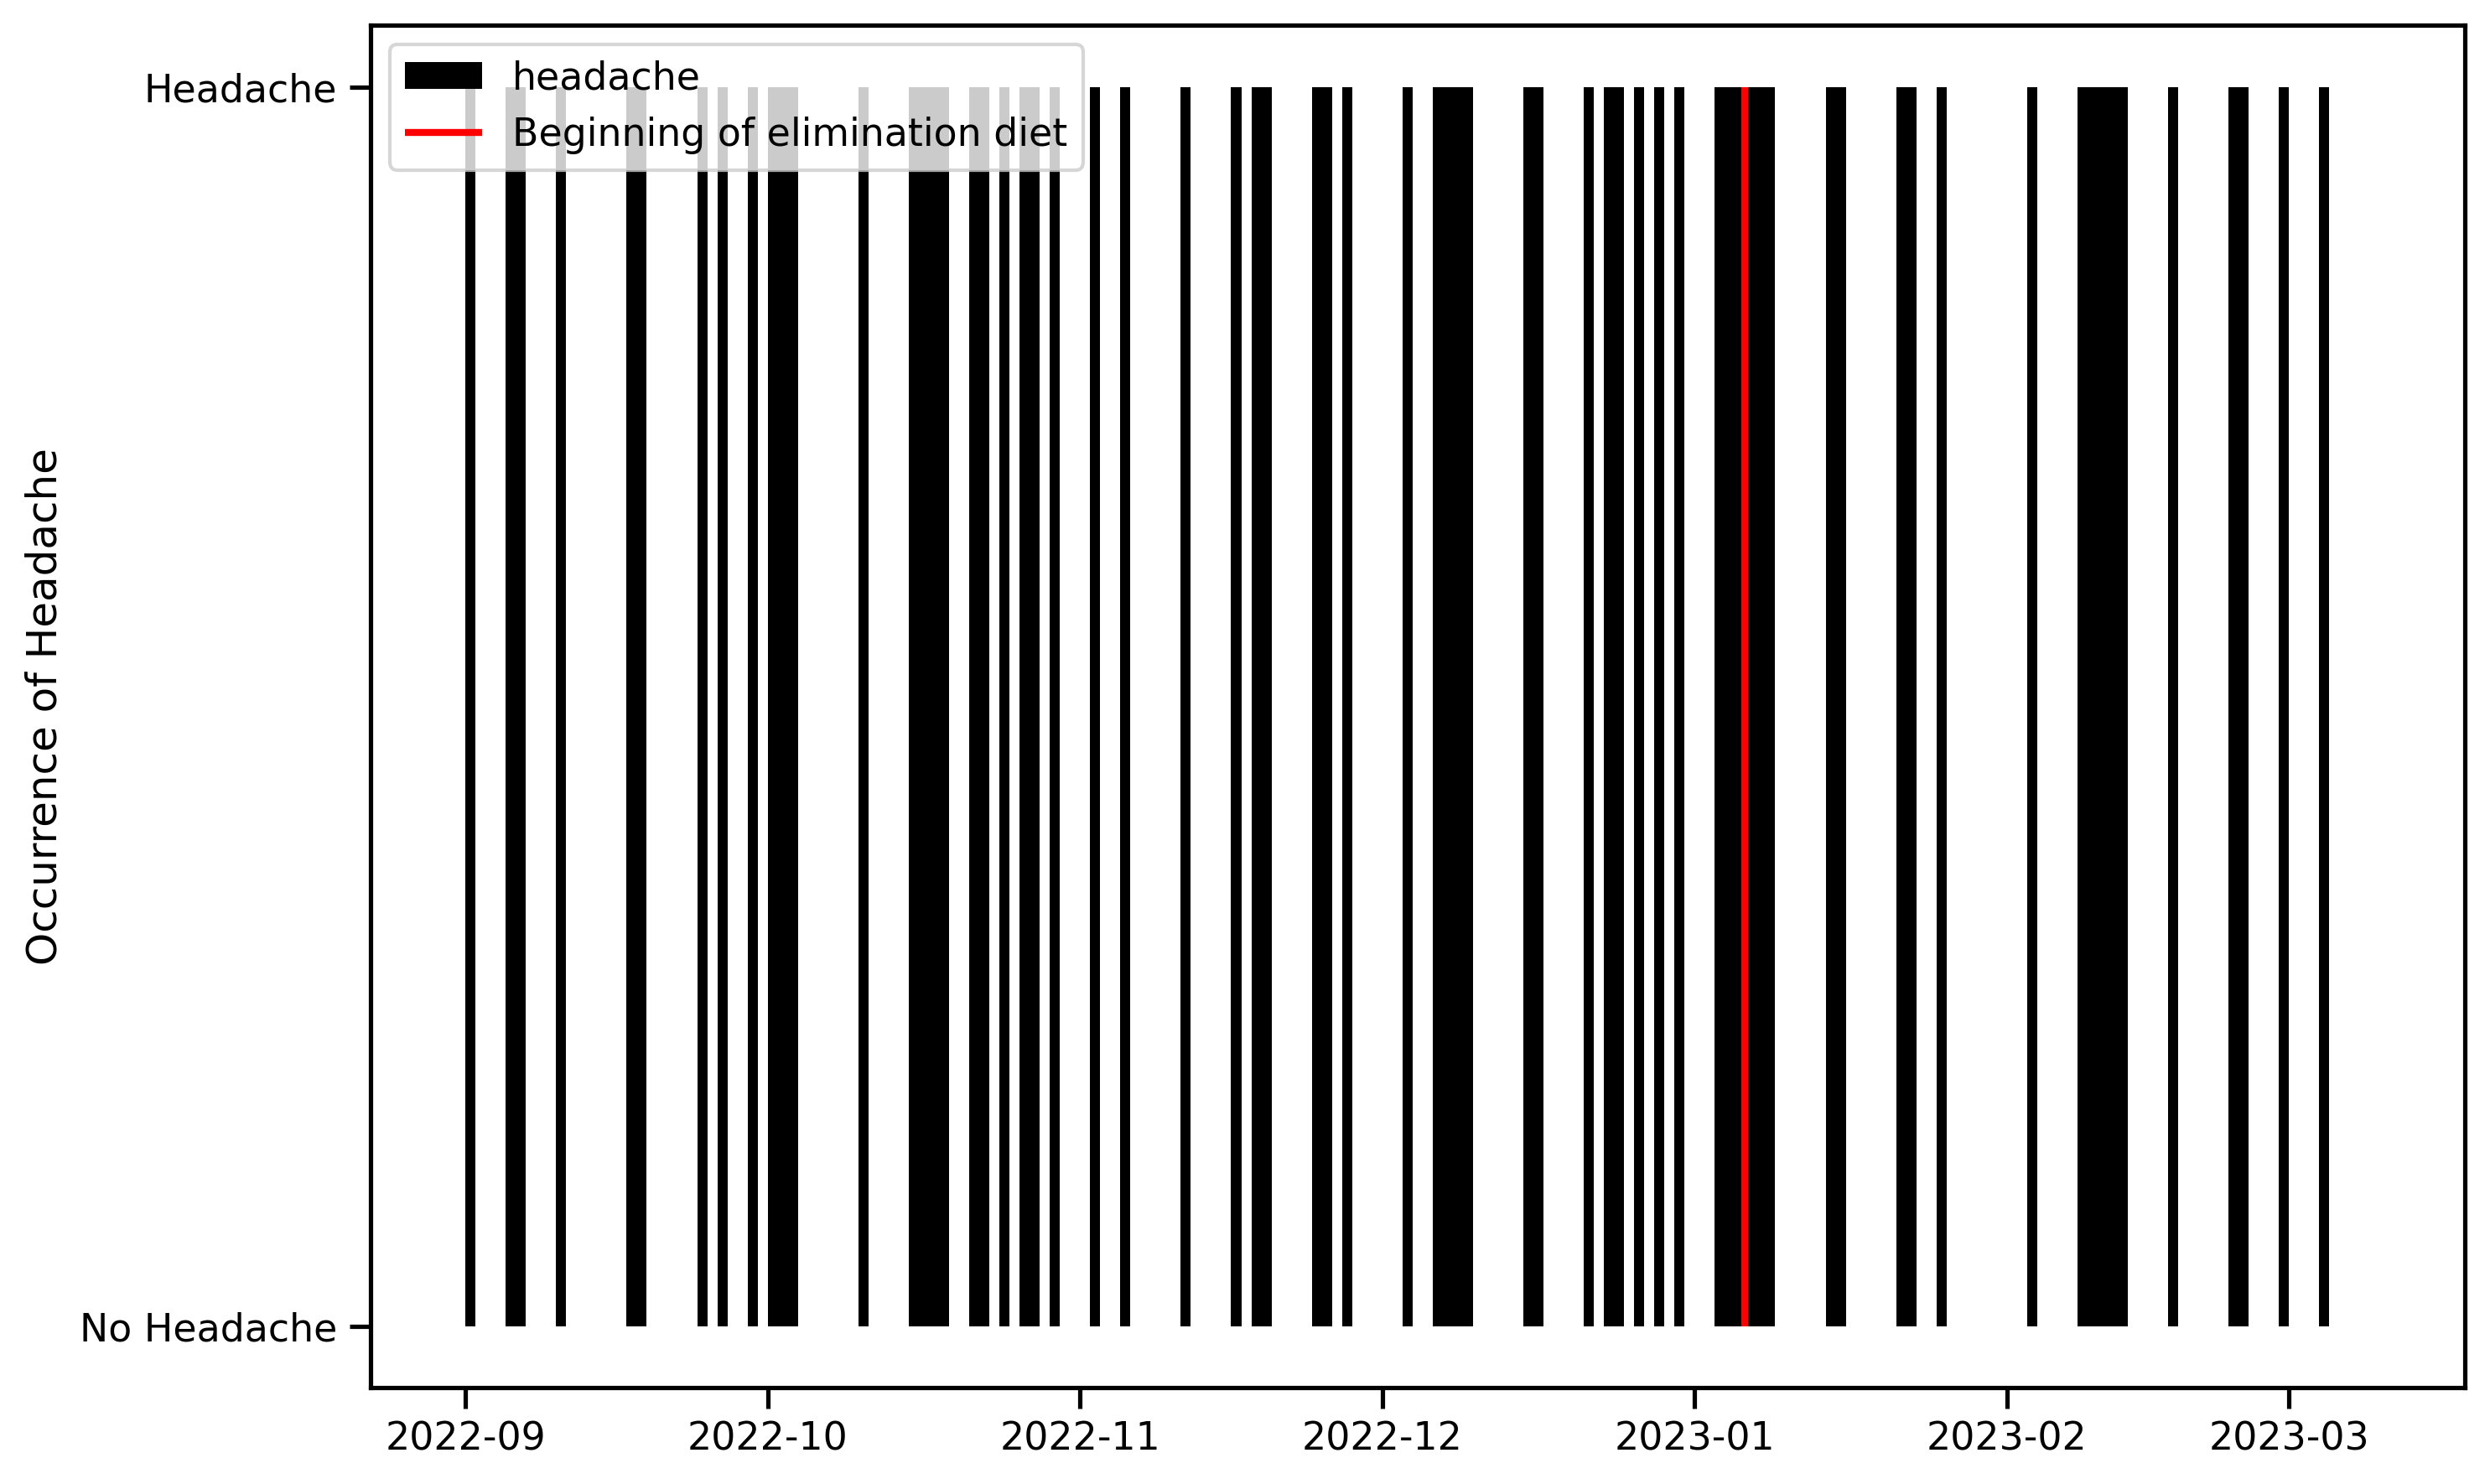

In [67]:
f, ax1 = plt.subplots(1, 1, dpi=300, figsize=(10, 6))

roll_window = 7

phase_b_start = pd.DatetimeIndex(["2023-01-06"])
madrid = pd.DatetimeIndex(["2023-02-17", "2023-02-27"])
restaurant = daylio[daylio.Restaurant == 1].loc["2022-09-01":].index


ax1.set_ylabel(f"Occurrence of Headache")

ax1.fill_between(
    daylio.Headache.loc["2022-09-01":].index,
    daylio.Headache.loc["2022-09-01":],
    step="pre",
    color="black",
    label="headache",
    linewidth=0,
)
ax1.vlines(
    phase_b_start,
    ymin=0,
    ymax=1,
    color="red",
    label="Beginning of elimination diet",
    linewidth=2,
)

ax1.set_yticks([1, 0])
ax1.set_yticklabels(['Headache', 'No Headache'])

ax1.legend(loc="upper left")
f.set_tight_layout(True)
plt.show()

In [41]:
daylio.Headache.loc["2022-01-06":"2022-03-09"].mean()*7

2.444444444444444

In [42]:
daylio.Headache.loc["2022-01-06":"2022-03-09"].std()*7

3.363838906127927

In [43]:
daylio.Headache.loc["2023-01-06":"2023-03-09"].mean()*7

2.2222222222222223

In [44]:
daylio.Headache.loc["2023-01-06":"2023-03-09"].std()*7

3.2845898474466826

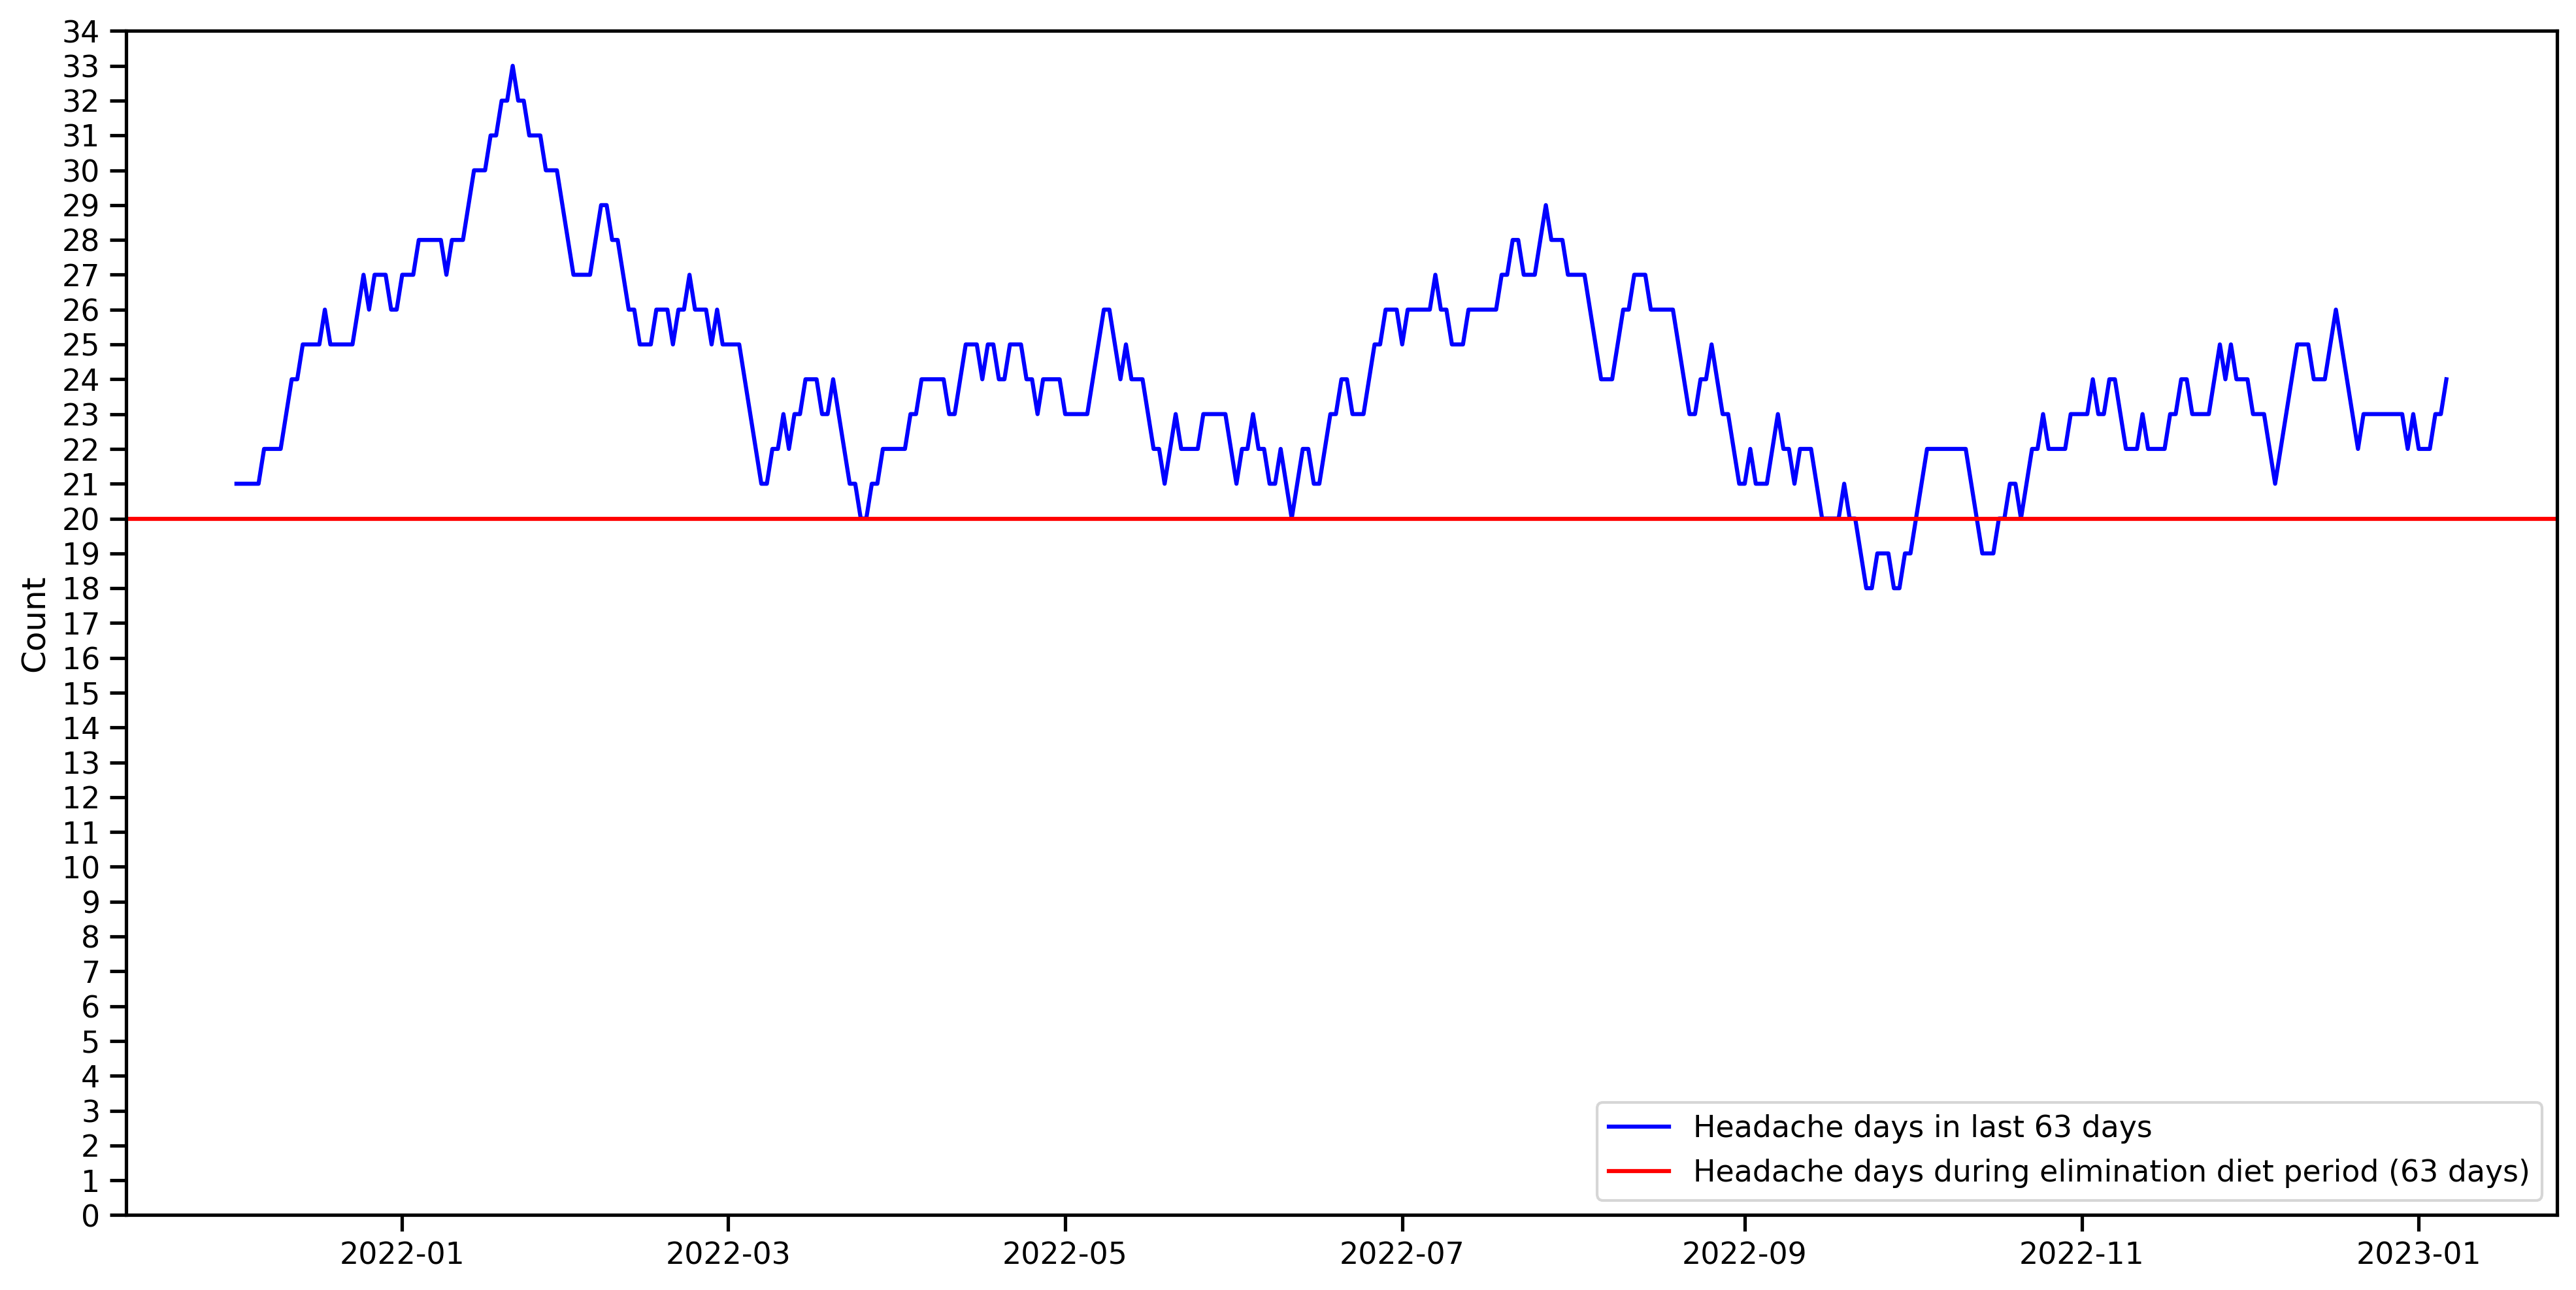

In [126]:
f, ax = plt.subplots(1, 1, figsize=(16, 8), dpi=300)

ax.plot(
    daylio.Headache["2021-10-01":"2023-01-06"].rolling(63).sum(),
    label="Headache days in last 63 days",
    color="blue",
)
ax.axhline(
    daylio.Headache.loc["2023-01-06":].sum(),
    color="red",
    label="Headache days during elimination diet period (63 days)",
)
ax.set_yticks(range(35))
ax.set_ylabel("Count")
plt.legend(loc="lower right")
plt.show()

In [118]:
pre_diet_days = len(daylio.Headache["2022-01-01":"2023-01-06"])
pre_diet_headache = daylio.Headache["2022-01-01":"2023-01-06"].sum()
pre_diet_no_headache = pre_diet_days - pre_diet_headache

In [119]:
diet_days = len(daylio.Headache["2023-01-06":])
diet_headache = daylio.Headache["2023-01-06":].sum()
diet_no_headache = diet_days - diet_headache

In [121]:
from scipy.stats import chi2_contingency
import numpy as np

In [122]:
cont_table = np.array(
    [[pre_diet_no_headache, pre_diet_headache], [diet_no_headache, diet_headache]]
)

In [123]:
chi2, p, dof, expected = chi2_contingency(cont_table)

In [125]:
p/2

0.20900953565076286

This is not less than 0.05 so we reject the null hypothesis that there was a statistically significant decrease in headache frequency with the diet. 

## Conclusion

There is not enough data to determine whether the diet helped significantly. Visually, It seems that it helped, but it will be very difficult to notice effects of re-introducing foods, and will require a lot of time. I don't have the patience for this. As such, I will stop the elimination diet, but remain cautious (update my priors) about what I should eat. I will proceed to other investigations. Namely, sleeping more and meditating.